In [1]:
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/COMP-6721")

Mounted at /content/drive


In [6]:
"""
Preparing the pickle
"""
from pathlib import Path

import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
from tqdm import tqdm
from pathlib import Path
import shutil


dirpath = Path('data/dataset')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
os.makedirs('data/dataset')
datasetPath = Path('data/dataset/dataset.zip')
gdd.download_file_from_google_drive(file_id='15yca0AIhQgY49H0M_V96lgadlG3zIYyA',
                                    dest_path=str(datasetPath),
                                    unzip=True)
# delete zip file
datasetPath.unlink()

datasetPath = Path('data/dataset')
maskPath = datasetPath/'with_mask'
nonMaskPath = datasetPath/'without_mask'
randomPath = datasetPath/'random'
maskDF = pd.DataFrame()

for imgPath in tqdm(list(maskPath.iterdir()), desc='with_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 1
    }, ignore_index=True)

for imgPath in tqdm(list(nonMaskPath.iterdir()), desc='without_mask'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 0
    }, ignore_index=True)

for imgPath in tqdm(list(randomPath.iterdir()), desc='random_images'):
    maskDF = maskDF.append({
        'image': str(imgPath),
        'mask': 2
    }, ignore_index=True)

dfName = 'data/dataset/dataset.pickle'
print(f'Saving Dataframe to: {dfName}')
maskDF.to_pickle(dfName)

Unzipping...

with_mask:   1%|          | 35/3725 [00:00<00:10, 341.39it/s]

Done.


random_images: 100%|██████████| 7663/7663 [00:22<00:00, 333.60it/s]

Saving Dataframe to: data/dataset/dataset.pickle


In [47]:
"""
The DataSet class
"""
from PIL import Image
import numpy as np
from torch import long, tensor
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor


class MaskDetectionDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = Compose([
            Resize((100, 100)),
            ToTensor(),
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = Image.open(row['image']).convert('RGB')
        return {
          'image': self.transformations(image),
          'mask': tensor([row['mask']], dtype=long),
          'path': row['image']
        }
    
    def __len__(self):
        return len(self.dataFrame.index)

In [48]:
"""
The CNN model
"""
import torch
import torch.nn.init as init
import torch.nn as nn
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential)

class FaceMaskDetectorCNN(nn.Module):
    def __init__(self):
        super(FaceMaskDetectorCNN, self).__init__()
        
        self.convLayer1 = convLayer1 = Sequential(
            Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1)),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2))
        )
        
        self.convLayer2 = convLayer2 = Sequential(
            Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2))
        )
        
        self.convLayer3 = convLayer3 = Sequential(
            Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1), stride=(3,3)),
            ReLU(),
            MaxPool2d(kernel_size=(2, 2))
        )
        
        self.linearLayers = linearLayers = Sequential(
            Linear(in_features=2048, out_features=1024),
            ReLU(),
            Linear(in_features=1024, out_features=3),
        )
        
        # Initialize layers' weights
        for sequential in [convLayer1, convLayer2, convLayer3, linearLayers]:
            for layer in sequential.children():
                if isinstance(layer, (Linear, Conv2d)):
                    init.xavier_uniform_(layer.weight)
    
    def forward(self, x: Tensor):
        """ forward pass
        """
        out = self.convLayer1(x)
        out = self.convLayer2(out)
        out = self.convLayer3(out)
        out = out.view(-1, 2048)
        out = self.linearLayers(out)
        return out

face_mask_detector_cnn = FaceMaskDetectorCNN()

In [49]:
"""
Some utilities
"""
from pathlib import Path
from typing import Dict, List, Union

import pandas as pd
import torch
import torch.nn.init as init
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.nn import (Conv2d, CrossEntropyLoss, Linear, MaxPool2d, ReLU,
                      Sequential)
from torch.optim import Adam
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

def prepare_data(mask_df_path) -> None:
        mask_df = pd.read_pickle(mask_df_path)
        train, validate = train_test_split(mask_df, test_size=0.3, random_state=0,
                                           stratify=mask_df['mask'])
        mask_num = mask_df[mask_df['mask']==1].shape[0]
        non_mask_num = mask_df[mask_df['mask']==0].shape[0]
        not_a_person_num = mask_df[mask_df['mask']==2].shape[0]
        n_samples = [non_mask_num, mask_num, not_a_person_num]
        normed_weights = [1 - (x / sum(n_samples)) for x in n_samples]
        return [
            MaskDetectionDataset(train),
            MaskDetectionDataset(validate),
            CrossEntropyLoss(weight=torch.tensor(normed_weights))
            ]

def train_dataloader(train_df) -> DataLoader:
    return DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)

def val_dataloader(validate_df) -> DataLoader:
    return DataLoader(validate_df, batch_size=32, num_workers=4)

train_df, validate_df, cross_entropy_loss = prepare_data("data/dataset/dataset.pickle")

In [50]:
"""
Training Step
"""

LEARNING_RATE = 0.00001

def train_model():
    optimizer = Adam(face_mask_detector_cnn.parameters(), lr=LEARNING_RATE)
    for epoch in range(2):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader(train_df), 0):
            inputs, labels = data['image'], data['mask']
            labels = labels.flatten()
            outputs = face_mask_detector_cnn(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

train_model()
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Finished Training


In [51]:
"""
Evaluate the model
"""
from numpy import vstack

def evaluate_model():
    predictions, actuals = np.array([]), np.array([])
    for i, data in enumerate(val_dataloader(validate_df)):
        inputs, targets = data['image'], data['mask']
        targets = targets.flatten()
        output = face_mask_detector_cnn(inputs)
        output = torch.argmax(output,axis=1)
        predictions = np.append(predictions,output.numpy())
        actuals = np.append(actuals,targets.numpy())
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc
print(evaluate_model())

0.5831325301204819


data/dataset/with_mask/with_mask_206.jpg
Actual: with_mask
Predicted: with_mask


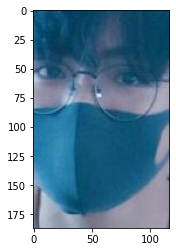

In [79]:
"""
Predict
"""

import matplotlib.pyplot as plt
import random

class_mapping = {
    0: "without_mask",
    1: "with_mask",
    2: "not_a_person"
}

def predict():
  data = iter(val_dataloader(validate_df))
  data = data.next()
  inputs,targets = data['image'], data['mask']
  output = face_mask_detector_cnn(inputs)
  output = torch.argmax(output,axis=1)
  rand_ind = random.choice(list(range(0,32)))
  print(data['path'][rand_ind])
  img = Image.open(data['path'][rand_ind])
  plt.imshow(np.asarray(img))
  print("Actual:", class_mapping[targets[rand_ind].tolist()[0]])
  print("Predicted:",class_mapping[output[rand_ind].tolist()])

predict()